In [2]:
import numpy as np
from helper import Particle, Point
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# customize plot
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 14
rcParams['font.family'] = 'StixGeneral'

In [3]:
n = 50
weight = 1/n
domain = 1

source_coord = np.random.random((n, 3)).tolist()
target_coord = (-np.random.random((n, 3))).tolist()
sources = [Particle(coord, w = weight) for coord in source_coord]
targets = [Particle(coord, w = weight) for coord in target_coord]

In [4]:
center = Point([domain/2, domain/2, domain/2])

In [5]:
def get_multipole(sources, center):
    dx = center.x - np.array([source.x for source in sources])
    dy = center.y - np.array([source.y for source in sources])
    dz = center.z - np.array([source.z for source in sources])
    w = np.array([source.w for source in sources])

    # calculate the contribution of each source
    multipole = w * [np.ones(n), dx, dy, dz, dx**2/2, dy**2/2, dz**2/2, dx*dy/2, dy*dz/2, dz*dx/2]
    multipole = np.sum(multipole[ : ], axis=1)
    return multipole

In [6]:
# given targets list, return the array of each target's distance from the point
def distance(targets_coord, point):
    return np.sqrt((targets_coord[0] - point.x)**2 + (targets_coord[1] - point.y)**2 + (targets_coord[2] - point.z)**2)

In [7]:
# given targets list, multipole and center, return the array of targets' potentials
def eval_potential(targets, multipole, center):
    x = np.array([target.x for target in targets])
    y = np.array([target.y for target in targets])
    z = np.array([target.z for target in targets])
    targets_coord = [x, y, z]
    r = distance(targets_coord, center)

    dx, dy, dz = x-center.x, y-center.y, z-center.z
    r3 = r**3
    r5 = r**5
    
    multipole_coef = [1/r, -dx/r3, -dy/r3, -dz/r3, 3*dx**2/r5 - 1/r3, 3*dy**2/r5 - 1/r3, \
                        3*dz**2/r5 - 1/r3, 3*dx*dy/r5, 3*dy*dz/r5, 3*dz*dx/r5]
    u = np.dot(multipole, multipole_coef)
    return u

In [8]:
multipole = get_multipole(sources, center)
u_multi = eval_potential(targets, multipole, center)

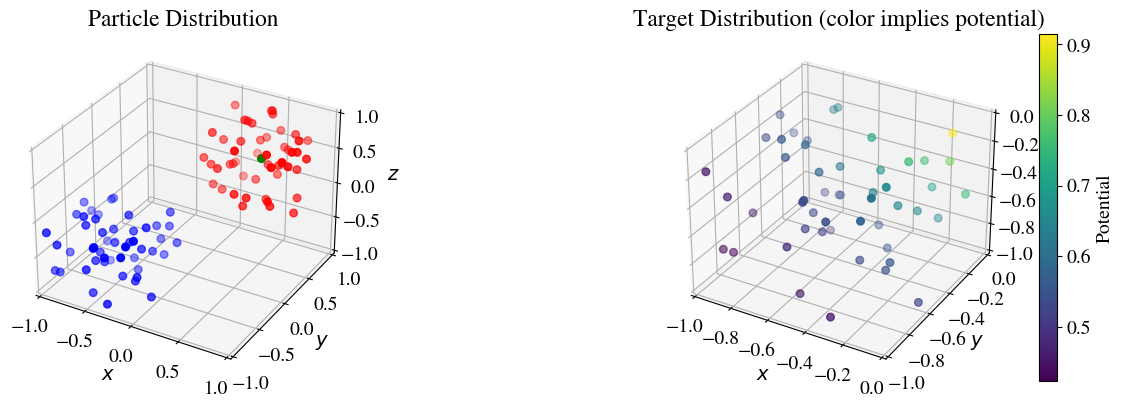

In [9]:
# plot spatial particle distribution
fig = plt.figure(figsize=(18,4.5))
# left plot
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter([target.x for target in targets], 
           [target.y for target in targets], 
           [target.z for target in targets], s=30, c='b')
ax.scatter([source.x for source in sources], 
           [source.y for source in sources], 
           [source.z for source in sources], s=30, c='r')

ax.scatter(center.x, center.y, center.z, s=30, c='g')

ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Particle Distribution')
# right plot
ax = fig.add_subplot(1,2,2, projection='3d')
scale = 100   # scale for dot size in scatter plot
u_min, u_max = np.min(u_multi), np.max(u_multi)
color_norm = plt.Normalize(u_min, u_max)
cmap = plt.cm.get_cmap('viridis')
scatter = ax.scatter([target.x for target in targets], 
           [target.y for target in targets], 
           [target.z for target in targets],
           s=30, c=u_multi, cmap = cmap, norm = color_norm)
ax.set_xlim3d(-1,0)
ax.set_ylim3d(-1,0)
ax.set_zlim3d(-1,0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Target Distribution (color implies potential)')

# Add colorbar legend
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Potential')
cbar.ax.set_position([3, 0.1, 0.03, 0.8])

plt.subplots_adjust(right=0.8)

plt.show()

In [10]:
# modified direct_sum
def direct_sum(sources, targets):
    for target in targets:
        for source in sources:
            r = target.distance(source)
            target.u += source.w / r

In [11]:
direct_sum(sources, targets)
u_direct = np.array([target.u for target in targets])

In [12]:
%timeit direct_sum(sources, targets)
%%timeit
multipole = get_multipole(sources, center)
eval_potential(targets, multipole, center)

4.11 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


UsageError: Line magic function `%%timeit` not found.


In [13]:
err = np.sqrt(sum((u_direct - u_multi)**2) / sum(u_direct**2))
print('L2 Norm error: {}'.format(err))

L2 Norm error: 0.003691971245120915


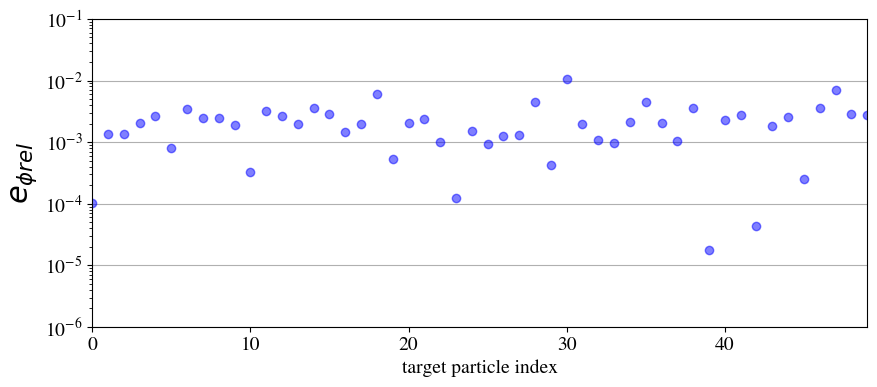

In [15]:
# plotting the relative error band
err_rel = abs((u_multi - u_direct) / u_direct)
plt.figure(figsize=(10,4))
ax = plt.gca()
plt.plot(range(n), err_rel, 'bo', alpha=0.5)
plt.xlim(0,n-1)
plt.ylim(1e-6, 1e-1)
ax.yaxis.grid()
plt.xlabel('target particle index')
plt.ylabel('$e_{\phi rel}$', fontsize=22)
ax.set_yscale('log')